# Detector Rates
The purpose of this notebook is to determine the relationship between bin values and actual energies.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import lmfit as lf
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interp

In [2]:
#Import data
data = pd.read_csv ("data/scanrate_06022022_3.csv")
data2 = pd.read_csv ("data/scanrate_d5_g20-200_0-8192_40_06032022.csv")
dataJ5 = pd.read_csv("data/scanwindow_06052022.csv")
data3A = pd.read_csv("../UniversalTrigger3A/data/scanwindow_06092022.csv")
dataJ9 = pd.read_csv("data/no_PuBe_scan_fix2.csv")
threshold = data.iloc[:,0]
threshold2 = data2.iloc[:,0]
thresholdJ5 = dataJ5.iloc[:,0]
threshold3A = data3A.iloc[:,0]
thresholdJ9 = dataJ9.iloc[:,0]
rate = data.iloc[:,1]
rate2 = data2.iloc[:,1]
rateJ5 = dataJ5.iloc[:,1]
rate3A = data3A.iloc[:,1]
rateJ9 = dataJ9.iloc[:,1]

#Cut an ill-behaved region
rate2 = rate2[threshold2 > 220]
threshold2 = threshold2[threshold2 > 220]
rate = rate[threshold > 220]
threshold = threshold[threshold > 220]

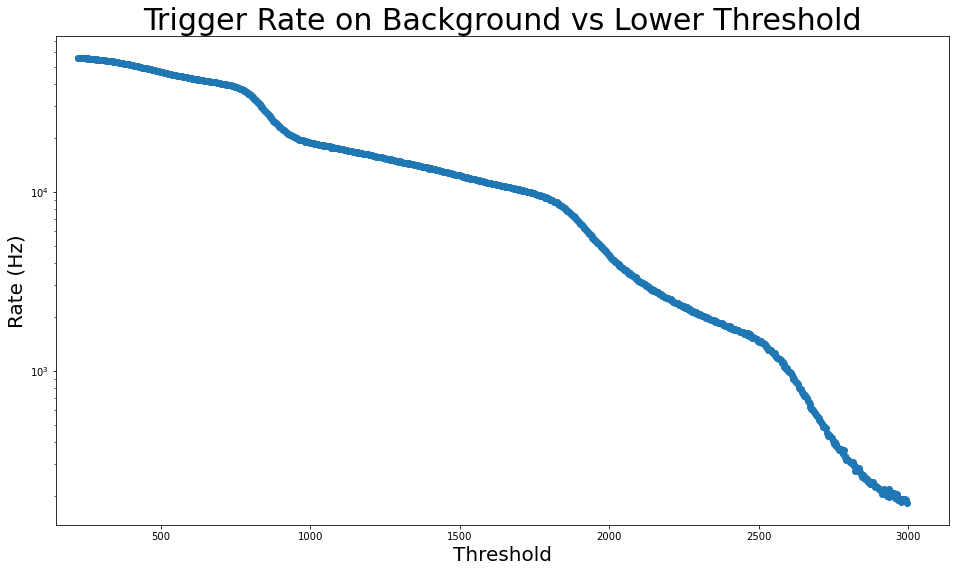

In [3]:
plt.figure(figsize=(16,9))

plt.scatter(threshold,rate)

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Trigger Rate on Background vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.yscale('log')
plt.xlim(150)
#plt.ylim(0)

plt.show()

In [4]:
diffs = np.zeros(len(threshold))
for i,n in enumerate(rate):
    try:
        diffs[i] = rate[i-1] - n
    except KeyError:
        diffs[i] = np.nan

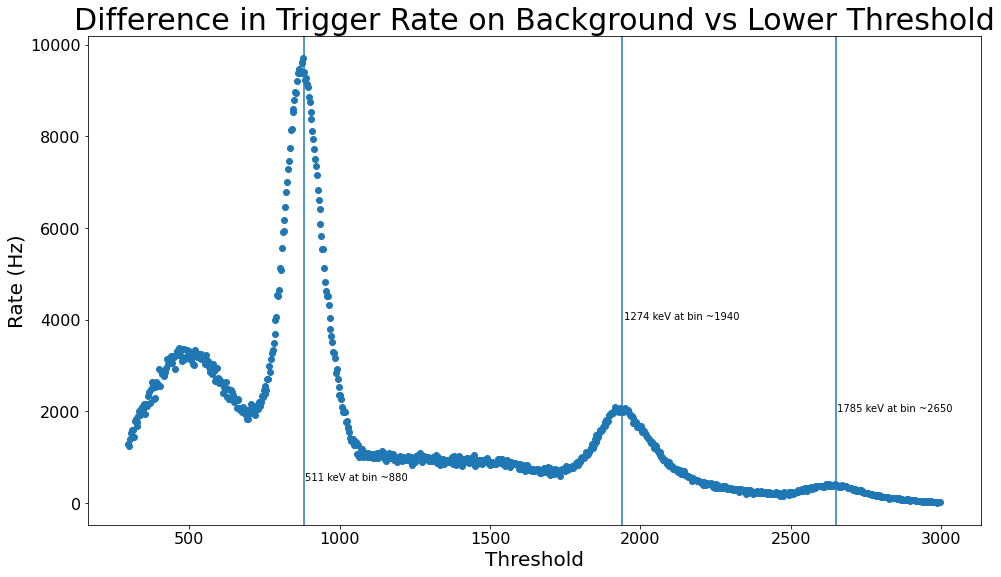

In [5]:
plt.figure(figsize=(16,9))

plt.scatter(threshold,diffs)

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Difference in Trigger Rate on Background vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
#plt.xlim(5000)
#plt.ylim(0)

plt.axvline(880)
plt.text(885,500,"511 keV at bin ~880")
plt.axvline(1940)
plt.text(1945,4000,"1274 keV at bin ~1940")
plt.axvline(2650)
plt.text(2655,2000,"1785 keV at bin ~2650")
point = [880,511]
point2 = [1940,1274]
point3 = [2650, 1785]

plt.show()

## Fitting the Bin/Energy Relationship
Note that we are only "fitting" to two points (drawing a line between them) as a rudimentary measure. This is partially due to the fact that the third point is not very clear, being both short and wide.

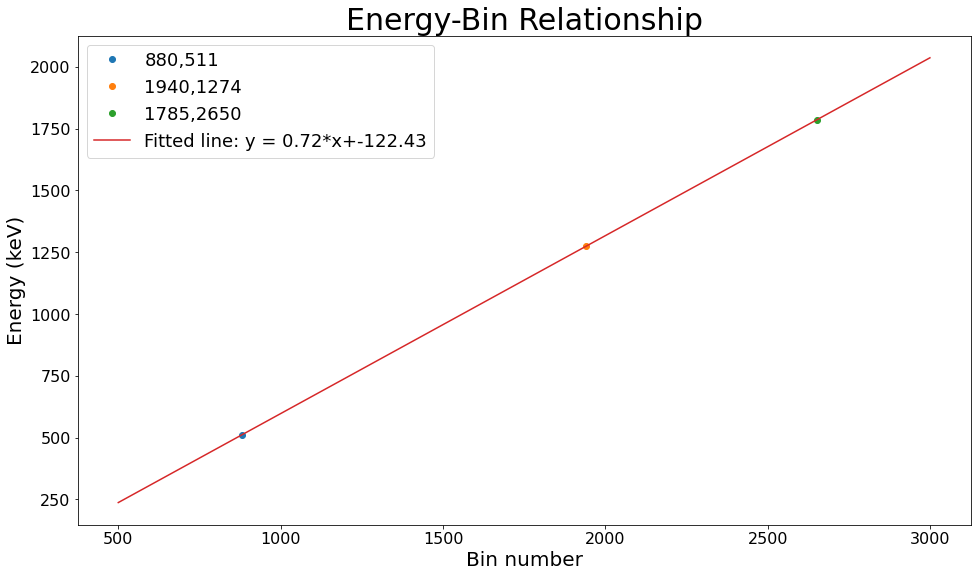

Sample Variance: 0.0021804912780326213


In [6]:
plt.figure(figsize=(16,9))

#We will plot all three of our points
plt.plot(point[0],point[1],"o",label="880,511")
plt.plot(point2[0],point2[1],"o",label="1940,1274")
plt.plot(point3[0],point3[1],"o",label="1785,2650")

#But fit to two of them
m = (point2[1] - point[1])/(point2[0]-point[0])
b = point2[1] - m*point2[0]

#These functions allow us to make convert threshold to energy and vice versa
def y(x):
    return m*x+b
def thresh(y):
    return (y - b)/m
x = np.arange(500,3000)
plt.plot(x,y(x),label="Fitted line: y = {:.2f}*x+{:.2f}".format(m,b))


#Let's take a look at the result:
plt.title("Energy-Bin Relationship - Quick Fit",fontsize=30)
plt.xlabel("Bin number",fontsize=20)
plt.ylabel("Energy (keV)",fontsize=20)
plt.legend(fontsize=18)
plt.show()

#And what is the variance from our line?
var = ((point3[1]-y(point3[0]))**2 + (point2[1]-y(point2[0]))**2 + (point[1]-y(point[0]))**2)/2
print("Sample Variance:",var)

## Checking the energy-bin relationship against a new data set
These results seem pretty good. Let's check them against a new set of data that goes a bit farther out.

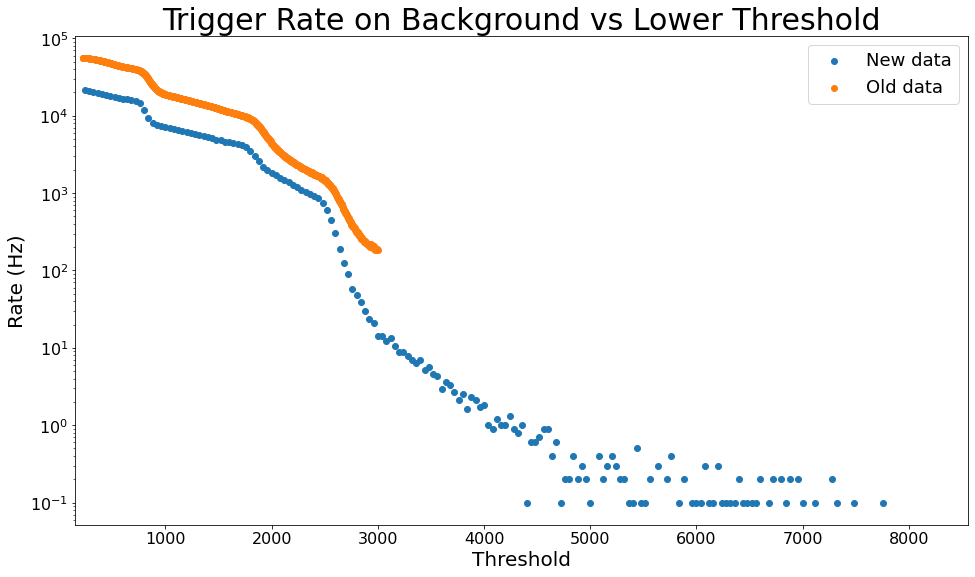

In [7]:
plt.figure(figsize=(16,9))

plt.scatter(threshold2,rate2,label="New data")
plt.scatter(threshold,rate,label="Old data")


plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Trigger Rate on Background vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.yscale('log')

plt.xlim(150)
#plt.ylim(0)

plt.legend(fontsize=18)
plt.show()

In [8]:
diffs2 = np.zeros(len(threshold2))
for i,n in enumerate(rate2):
    try:
        diffs2[i] = rate2[i-1] - n
    except KeyError:
        diffs2[i] = np.nan

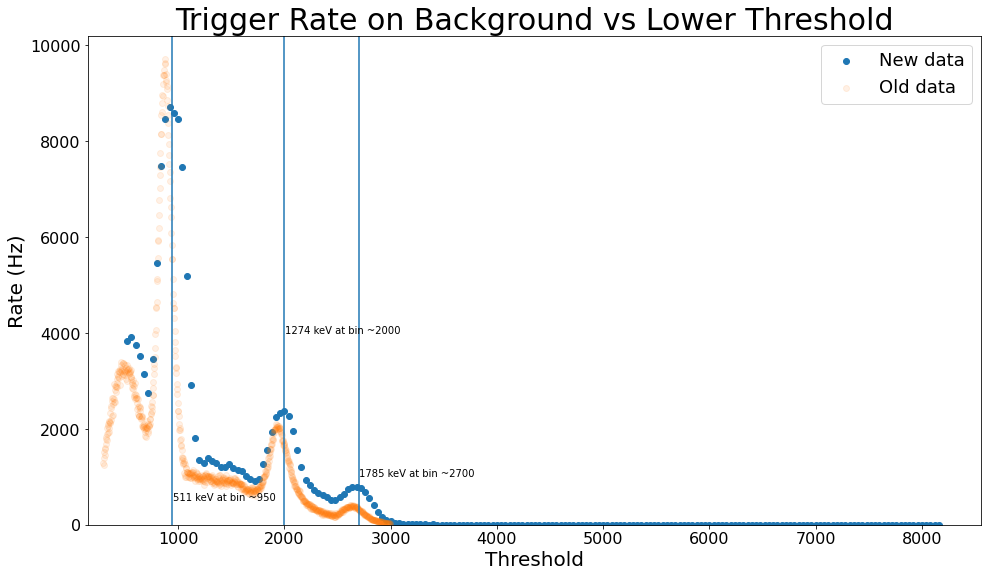

In [9]:
plt.figure(figsize=(16,9))

plt.scatter(threshold2,diffs2,label="New data")
plt.scatter(threshold,diffs,label="Old data",alpha=0.1)

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Trigger Rate on Background vs Lower Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
#plt.yscale('log')

plt.xlim(150)
plt.ylim(0)

plt.axvline(2000)
plt.text(2005,4000,"1274 keV at bin ~2000")
plt.axvline(2700)
plt.text(2705,1000,"1785 keV at bin ~2700")
plt.axvline(945)
plt.text(950,500,"511 keV at bin ~950")

p = [945,511]
p1 = [2000,1274]
p2 = [2700,1785]
plt.legend(fontsize=18)
plt.show()

## A Proper Fit
These are already clearly misaligned. Let's do a real fit to all six data points.

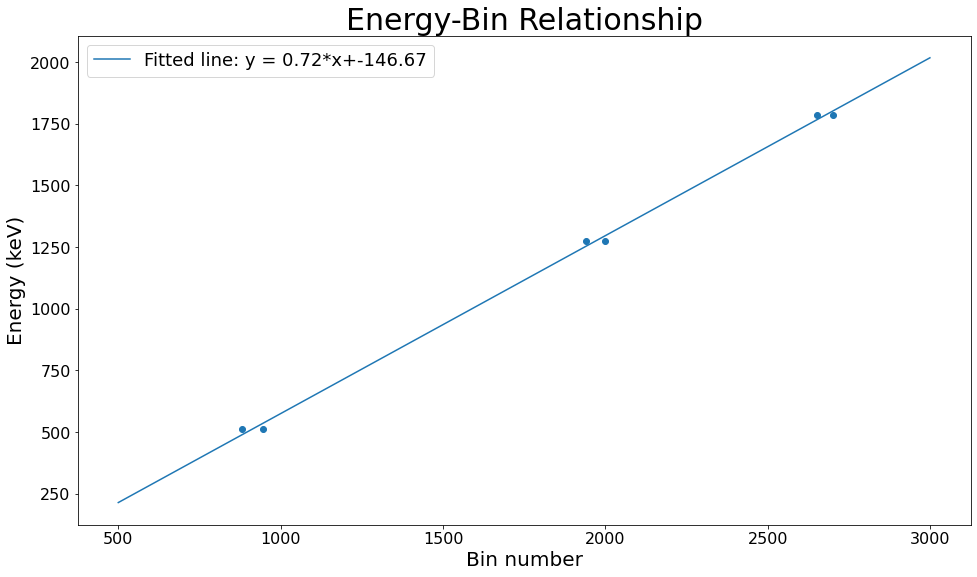

In [13]:
#Set up our model
def f(x,m,b):
    return m*x+b
l_model = lf.Model(f)
params = l_model.make_params(m=m,b=b) #Use our old 'fit' for inital guesses.

#Zip our data together.
ydat = [x[1] for x in [p,p1,p2,point,point2,point3]]
xdat = [x[0] for x in [p,p1,p2,point,point2,point3]]

#Do the fit
l_fit = l_model.fit(ydat,params,x=xdat)
l_dict = l_fit.best_values
l_m = l_dict['m']
l_b = l_dict['b']
l_curve = f(x,l_m,l_b)

#plot it
plt.figure(figsize=(16,9))
plt.scatter(xdat,ydat)
plt.plot(x,l_curve,label="Fitted line: y = {:.2f}*x+{:.2f}".format(l_m,l_b))
plt.title("Energy-Bin Relationship",fontsize=30)
plt.xlabel("Bin number",fontsize=20)
plt.ylabel("Energy (keV)",fontsize=20)
plt.legend(fontsize=18)
plt.show()

l_fit